In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from filelock import FileLock
import numpy as np
import ray
import sys
sys.path.append("../src/")
from consistent_hashing import ConsistentHash
import math 
from time import time
def get_data_loader():
    
    """Safely downloads data. Returns training/validation set dataloader."""
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )

    # We add FileLock here because multiple workers will want to
    # download data, and this may cause overwrites since
    # DataLoader is not threadsafe.
    
    class MNISTEvenOddDataset(torch.utils.data.Dataset):
        def __init__(self, ready_data):
            self.img_data = ready_data.data
            self.labels = ready_data.targets % 2
        
        def __len__(self):
            return len(self.labels)
    
        def __getitem__(self, ind):
            return torch.true_divide(self.img_data[ind].view(-1, 28 * 28).squeeze(), 255), torch.tensor([self.labels[ind]])


    
    with FileLock(os.path.expanduser("~/data.lock")):
        
        train_dataset = datasets.MNIST(
                "~/data", train=True, download=True, transform=mnist_transforms
            )
        
        test_dataset = datasets.MNIST("~/data", train=False, transform=mnist_transforms)
        
        train_loader = torch.utils.data.DataLoader(
            MNISTEvenOddDataset(train_dataset),
            batch_size=128,
            shuffle=True,
        )
        test_loader = torch.utils.data.DataLoader(
             MNISTEvenOddDataset(test_dataset),
            batch_size=128,
            shuffle=False,
        )
    return train_loader, test_loader


def evaluate(model, test_loader):
    """Evaluates the accuracy of the model on a validation dataset."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # This is only set to finish evaluation faster.
            if batch_idx * len(data) > 1024:
                break
            outputs = nn.Sigmoid()(model(data))
            #_, predicted = torch.max(outputs.data, 1)
            predicted = outputs > 0.5
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100.0 * correct / total

In [2]:
class LinearNet(nn.Module):
    """Small Linear Network for MNIST."""

    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc_weights = nn.ParameterList([nn.Parameter(torch.empty(1)) for weight in range(784)])
        init_fc = [nn.init.uniform_(x) for x in self.fc_weights]
        
        self.fc_bias = nn.Parameter(torch.empty(1))
        nn.init.uniform_(self.fc_bias)
        
    #def __init__(self):
    #    super(LinearNet, self).__init__()
    #    self.fc = nn.Linear(28*28, 1)
    #    nn.init.normal(self.fc.weight)

    #def forward(self, x):
    #    x = self.fc(x)
    #    return x
    
    def forward(self, x):
        #fc_layer = torch.cat(tuple(self.fc_weights)).unsqueeze(0)
        #x = x @ fc_layer.T + self.fc_bias
        for i, param in enumerate(self.fc_weights):
            if i==0:
                p=x[:,i]*param
            else:
                p += x[:,i]*param
        x = p.unsqueeze(1) + self.fc_bias
        return x
    
    def get_weights(self):
        return {k: v.cpu() for k, v in self.state_dict().items()}

    def set_weights(self, keys, weights): 
        flatten_weights =  [item for sublist in weights for item in sublist]
        self.load_state_dict({keys[i]:flatten_weights[i] for i in range(len(keys))})
        
    def get_gradients(self, keys):
        grads = {}

        for name, p in self.named_parameters():
            if name in keys:
                grad = None if p.grad is None else p.grad.data.cpu().numpy()
                grads[name] = grad

        return [grads[key] for key in keys]

    def set_gradients(self, gradients):
        for g, p in zip(gradients, self.parameters()):
            if g is not None:
                p.grad = torch.from_numpy(g)

In [3]:
@ray.remote  
class ParameterServer(object):
    def __init__(self, keys, values):
        self.weights = dict(zip(keys, values))

    def apply_gradients(self, keys, lr, *values):
        summed_gradients = [
            np.stack(gradient_zip).sum(axis=0) for gradient_zip in zip(*values)
        ]
    
        idx = 0
        for key, value in zip(keys, summed_gradients):
            self.weights[key] -= lr * torch.from_numpy(summed_gradients[idx])
            idx+=1

        return [self.weights[key] for key in keys]
    
    def add_weight(self, key, value):
        self.weights[key] = value
    
    def get_len(self):
        return len(self.weights)
    
    def get_weights(self, keys):
        return [self.weights[key] for key in keys]


In [4]:
@ray.remote
class DataWorker(object):
    def __init__(self, keys):
        self.model = LinearNet()
        self.data_iterator = iter(get_data_loader()[0])
        self.keys = keys
        self.key_set = set(self.keys)
        for key, value in dict(self.model.named_parameters()).items():
            if key not in self.key_set:
                value.requires_grad=False

        
    def update_weights(self, keys, *weights):
        self.model.set_weights(keys, weights)
        
#     def update_weights_selected(self, keys, *weights):
#         curr_state_dict = dict(self.model.state_dict().items())
#         flatten_weights =  [item for sublist in weights for item in sublist]
#         for i, key in enumerate(keys):
#             curr_state_dict[keys] = flatten_weights[i]
#         self.model.load_state_dict(curr_state_dict)
        
    def update_trainable(self, keys):
        self.keys = keys
        self.key_set = set(self.keys)
        for key, value in dict(self.model.named_parameters()).items():
            if key in self.key_set:
                value.requires_grad = True
            else:
                value.requires_grad = False
       

    def compute_gradients(self):
        #self.model.set_weights(keys, weights)
        try:
            data, target = next(self.data_iterator)
        except StopIteration:  # When the epoch ends, start a new epoch.
            self.data_iterator = iter(get_data_loader()[0])
            data, target = next(self.data_iterator)
        
        self.model.zero_grad()
        output = self.model(data)
        loss = nn.BCEWithLogitsLoss()(output, target.float())
        loss.backward()
        
        return self.model.get_gradients(self.keys)

In [18]:
iterations = 100
num_workers = 1 # number of workers per server
num_servers = 5 # number of servers
hashes_per_server = 100

def Scheduler(num_servers, hashes_per_server=50):
    
    model = LinearNet()
    key_values = model.get_weights()
    keys = np.array(list(key_values.keys()))
    #print(keys)
    #print(key_values) z
    values = [key_values[key] for key in keys]
    #values = [key_values[key] for key in keys]
    
    key_indices = {key: x for x, key in enumerate(keys)}
   
    # distributing weights across servers - do this using consistency hashing
    server_ids = ["server" + str(ind) for ind in range(num_servers)]
    hasher = ConsistentHash(keys, server_ids, hashes_per_server)
    servers = [ParameterServer.remote(keys[[key_indices[key] for key in hasher.get_keys_per_node()[serv]]], 
                                      [values[key_indices[key]] for key in hasher.get_keys_per_node()[serv]]) for serv in server_ids]
    # servers = [ParameterServer.remote(keys[0:1], values[0:1]), ParameterServer.remote(keys[1:2], values[1:2])]
    
    return hasher, servers, keys, model, hasher.get_keys_per_node(), server_ids.copy()

hasher, servers, keys, model, weight_assignments, server_ids =  Scheduler(num_servers, hashes_per_server)
ray.init(ignore_reinit_error=True)

# creating equal workers per server

workers = [[DataWorker.remote(weight_assignments["server" + str(j)]) for i in range(num_workers)] for j in range(num_servers)]





2022-05-31 21:17:03,600	INFO worker.py:963 -- Calling ray.init() again after it has already been called.


In [6]:
servers

[Actor(ParameterServer, aeee65985d4641ba756498cd01000000),
 Actor(ParameterServer, f56644e366d09b448f3163ed01000000),
 Actor(ParameterServer, 09925249890f610c05ef082901000000),
 Actor(ParameterServer, 787e81a6b1b7ca44d557a2e701000000),
 Actor(ParameterServer, b2512bfecd02d5bacf6d264f01000000)]

In [7]:
len(weight_assignments["server0"])

160

In [8]:
server_ids

['server0', 'server1']

In [19]:
test_loader = get_data_loader()[1]


In [20]:
print("Running synchronous parameter server training.")
lr=0.1
failure_iter=200
failure_server="server1"

# we need to get a new keys order because we are not assuming a ordering in keys
current_weights = []
keys_order = []
acc_vals = []

for j in range(num_servers):
    keys_order.extend(weight_assignments[server_ids[j]])
    current_weights.append(ray.get(servers[j].get_weights.remote(weight_assignments[server_ids[j]]))) 
curr_weights_ckpt = current_weights.copy()

time_per_iteration = []
for i in range(iterations):
 
    #start = time()
    
    if i == failure_iter:
        server_ids_old = server_ids.copy()
        weight_assignments_old = weight_assignments.copy()
        #Define parameters that will need to be moved
        failure_params = weight_assignments[failure_server]
        #Delete server from hash ring and reassign params
        hasher.delete_node_and_reassign_to_others(failure_server)
        weight_assignments = hasher.get_keys_per_node()
        #Update servers and workers
        num_servers -= 1
        server_ind = server_ids.index(failure_server)
        server_ids = server_ids[0 : server_ind] + server_ids[server_ind + 1 : ]
        servers = servers[0 : server_ind] + servers[server_ind + 1 : ]
        workers = workers[0 : server_ind] + workers[server_ind + 1 : ]
        #Add each relevant parameter to its new server
        server_dict = {server_ids[x]:servers[x] for x in range(len(server_ids))}
        for ind, param in enumerate(failure_params):
            server_dict[hasher.get_key_to_node_map()[param]].add_weight.remote(param, curr_weights_ckpt[server_ind][ind])
        for server in server_ids:
            sid = server_ids_old.index(server)
            for ind, param in enumerate(weight_assignments_old[server]):
                server_dict[server].add_weight.remote(param, curr_weights_ckpt[sid][ind])
        #Update these parameters for each worker to make them trainable
        [workers[j][idx].update_trainable.remote(weight_assignments[server_ids[j]]) for  idx  in range(num_workers) for j in range(num_servers)]
        #print("at failure", np.mean(current_weights))
        current_weights = curr_weights_ckpt.copy()
        #print("at failure", np.mean(current_weights))
        [workers[j][idx].update_weights.remote(keys_order, *current_weights) for  idx  in range(num_workers) for j in range(num_servers)]

    #time_per_iteration.append(end-start)

    if i % 1 == 0:
        #print(len(keys_order))
        #print(len(current_weights[0]))
        # Evaluate the current model.
        #current_weights = [servers[j].get_weights.remote(weight_assignments["server" + str(j)]) for j in range(num_servers)] 
      
        # we are once again using the server to key mapping to set the weight back
        
        model.set_weights(keys_order, current_weights)
        accuracy = evaluate(model, test_loader)
        acc_vals.append(accuracy)
        print("Iter {}: \taccuracy is {:.1f}".format(i, accuracy))
   

  
    # sync all weights on workers
    if i % 5 == 0:

#         print("before",np.mean(curr_weights_ckpt[0]))
        curr_weights_ckpt = current_weights.copy()
#         print("after",np.mean(curr_weights_ckpt[0]))

        # get weights from server
        #current_weights = [servers[j].get_weights.remote(weight_assignments["server" + str(j)]) for j in range(num_servers)] 

        # update weights on all workers
        [workers[j][idx].update_weights.remote(keys_order, *current_weights) for  idx  in range(num_workers) for j in range(num_servers)]
    
        
    # use local cache of weights and get gradients from workers
    gradients = [[workers[j][idx].compute_gradients.remote() for  idx  in range(num_workers)] for j in range(num_servers)]

#     start = time()

    if i == failure_iter:
        keys_order = []
        for j in range(num_servers):
            keys_order.extend(weight_assignments[server_ids[j]])


    # Updates gradients to specfic parameter servers
    current_weights_t = [servers[j].apply_gradients.remote(weight_assignments[server_ids[j]], lr, *gradients[j]) for j in range(num_servers)]
    current_weights = ray.get(current_weights_t)

       
    end = time()

      

    #rint("\n")

#print("Final accuracy is {:.1f}.".format(accuracy))
# Clean up Ray resources and processes before the next example.
ray.shutdown()


Running synchronous parameter server training.
Iter 0: 	accuracy is 51.9
Iter 1: 	accuracy is 51.9
Iter 2: 	accuracy is 51.9
Iter 3: 	accuracy is 51.9
Iter 4: 	accuracy is 51.9
Iter 5: 	accuracy is 51.9
Iter 6: 	accuracy is 51.9
Iter 7: 	accuracy is 51.9
Iter 8: 	accuracy is 51.9
Iter 9: 	accuracy is 51.9
Iter 10: 	accuracy is 51.9
Iter 11: 	accuracy is 51.9
Iter 12: 	accuracy is 51.9
Iter 13: 	accuracy is 51.9
Iter 14: 	accuracy is 51.9
Iter 15: 	accuracy is 51.9
Iter 16: 	accuracy is 51.9
Iter 17: 	accuracy is 51.9
Iter 18: 	accuracy is 51.9
Iter 19: 	accuracy is 51.9
Iter 20: 	accuracy is 52.3
Iter 21: 	accuracy is 52.3
Iter 22: 	accuracy is 52.7
Iter 23: 	accuracy is 49.7
Iter 24: 	accuracy is 45.7
Iter 25: 	accuracy is 43.5
Iter 26: 	accuracy is 44.4
Iter 27: 	accuracy is 44.8
Iter 28: 	accuracy is 45.8
Iter 29: 	accuracy is 46.6
Iter 30: 	accuracy is 47.1
Iter 31: 	accuracy is 48.1
Iter 32: 	accuracy is 49.7
Iter 33: 	accuracy is 51.8
Iter 34: 	accuracy is 53.5
Iter 35: 	accuracy

In [11]:
np.mean(time_per_iteration[1:])

/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [12]:
np.std(time_per_iteration[1:])

/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [13]:
time_per_iteration

[]

In [14]:
server_ids

['server0', 'server1']

In [15]:
server_ids.index("server4")

ValueError: 'server4' is not in list

In [ ]:
hasher.get_key_to_node_map()['fc_bias']

In [ ]:
testmodel=LinearNet()

In [ ]:
dict(testmodel.state_dict().items())

In [ ]:
len(current_weights[0])

In [ ]:
servers[0].weights

In [ ]:
sum([184, 198, 191, 212])
len(acc_vals)

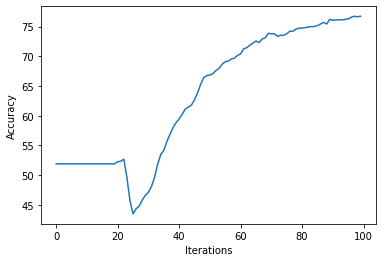

In [21]:
import matplotlib.pyplot as plt
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(acc_vals)

In [22]:
acc_vals[55:65]

[69.09722222222223,
 69.18402777777777,
 69.53125,
 69.70486111111111,
 70.13888888888889,
 70.39930555555556,
 71.26736111111111,
 71.44097222222223,
 71.875,
 72.22222222222223]

In [23]:
do_failure_test = False